# Full Demo Notebook: From Loading to Plotting

This notebook demonstrates a complete workflow:
1. Load and preprocess fiber photometry sessions.
2. Inspect available data (events, brain regions).
3. Define a helper function to preprocess and plot signals.
4. Extract event-aligned signals for a chosen event and region.
5. Plot mean ± 95% confidence interval of the signal.

Link: https://github.com/sebeliassen/FiberphotometryCode

```bash
conda install \
  numpy scipy pandas matplotlib jupyterlab \
  pytest tqdm statsmodels openpyxl \
  -c conda-forge -y


## 1. Setup: Imports and Session Loading

This cell contains the boilerplate code for loading raw fiber photometry sessions. “Boilerplate” refers to the standard, repetitive code needed to:
- Configure the Python path
- Import required libraries and modules
- Define the baseline data directory
- Load the first three CPT sessions (automatically removing any with bad signals)

In [1]:
# 1. Setup: Imports and Session Loading
import sys  # to modify Python path if needed
sys.path.append('../../../')  # adjust path to reach your project root

import warnings
import pytest
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt

from fiberphotometry.config import PLOTTING_CONFIG
from fiberphotometry.data.data_loading import DataContainer, load_all_sessions
from fiberphotometry.data.session_loading import populate_containers
from fiberphotometry.data.syncer import sync_session
from fiberphotometry.data.timepoint_processing import create_event_idxs_container_for_sessions
from fiberphotometry.processing.plotting_setup import PlottingSetup
from fiberphotometry.processing.signal_info_setup import assign_sessions_signal_info

# Define the path to your baseline data directory
baseline_path = Path("../../../Baseline")

# Load the first 3 CPT sessions, removing any flagged as bad signal
sessions = load_all_sessions(
    baseline_dir=str(baseline_path),
    session_type="cpt",
    first_n_dirs=20,
    remove_bad_signal_sessions=True
)

Processing trial directories:   0%|          | 0/20 [00:00<?, ?it/s]/Users/fsp585/Desktop/gether-demo/FiberphotometryCode/fiberphotometry/notebooks/demos/../../../fiberphotometry/data/data_loading.py:375: UserWarning: Both XLSX and CSV trial‐guide files found for T1 in ../../../Baseline/T1_23.25.29.e. Using 'T1_trial_guide.xlsx'.
  warnings.warn(
Processing trial directories:   5%|▌         | 1/20 [00:00<00:08,  2.14it/s]/Users/fsp585/Desktop/gether-demo/FiberphotometryCode/fiberphotometry/notebooks/demos/../../../fiberphotometry/data/data_loading.py:375: UserWarning: Both XLSX and CSV trial‐guide files found for T2 in ../../../Baseline/T2_23.25.29.e_2. Using 'T2_trial_guide.xlsx'.
  warnings.warn(
/Users/fsp585/Desktop/gether-demo/FiberphotometryCode/fiberphotometry/notebooks/demos/../../../fiberphotometry/data/data_loading.py:375: UserWarning: Both XLSX and CSV trial‐guide files found for T3 in ../../../Baseline/T3_23.25.29.e_4. Using 'T3_trial_guide.xlsx'.
  warnings.warn(
/Users/fs

In [2]:
# Print basic info (trial directory & mouse ID) for each session
for session in sessions:
    print(f'session found in {session.trial_dir} for mouse {session.mouse_id}')


session found in ../../../Baseline/T1_23.25.29.e for mouse 23
session found in ../../../Baseline/T1_23.25.29.e for mouse 25
session found in ../../../Baseline/T1_23.25.29.e for mouse 29
session found in ../../../Baseline/T2_23.25.29.e_2 for mouse 23
session found in ../../../Baseline/T2_23.25.29.e_2 for mouse 25
session found in ../../../Baseline/T2_23.25.29.e_2 for mouse 29
session found in ../../../Baseline/T3_23.25.29.e_4 for mouse 23
session found in ../../../Baseline/T3_23.25.29.e_4 for mouse 25
session found in ../../../Baseline/T3_23.25.29.e_4 for mouse 29
session found in ../../../Baseline/T4_31.33.35.37 for mouse 31
session found in ../../../Baseline/T4_31.33.35.37 for mouse 33
session found in ../../../Baseline/T4_31.33.35.37 for mouse 35
session found in ../../../Baseline/T4_31.33.35.37 for mouse 37
session found in ../../../Baseline/T5_31.33.35.37_3 for mouse 31
session found in ../../../Baseline/T5_31.33.35.37_3 for mouse 33
session found in ../../../Baseline/T5_31.33.35.3

In [3]:
# Print basic info (trial directory & mouse ID) for each session
for session in sessions:
    print(f'session found in {session.task}')

session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
session found in CPT_stage4_baseline
s

## 2. Populate Data Containers

This cell “attaches” all raw and photometry data files to each `Session` object. In object‐oriented programming, we store related data as attributes on an instance—here, that means adding a `dfs` container (a folder of DataFrames) and metadata directly to each `session`.

In practice, `populate_containers(sessions)` loops over every session and:
1. Finds matching files on disk (raw CSV, photometry streams, etc.).
2. Reads them into pandas DataFrames (handling headers, filtering columns, etc.).
3. Stores each DataFrame under a descriptive key in `session.dfs`.
4. Adds any metadata (e.g., `session.raw_attributes`, `session.signal_meta`) so later steps know what signals and ROIs are available.

In [4]:
# 2. Populate Data Containers
populate_containers(sessions) 

Below, we print out the name, number of rows, and column names for each DataFrame in the first session’s `dfs`. This shows how, once attached, you can easily access any table of data for that session. Remember: a pandas DataFrame is essentially a table where each column is a named variable and each row is one timepoint or trial entry.

In [5]:
for df_name, df in sessions[0].dfs.data.items():
    print(f"'{df_name}' DataFrame has {len(df)} rows and columns:")
    print("   ", list(df.columns))

'raw' DataFrame has 8802 rows and columns:
    ['Evnt_Time', 'Evnt_ID', 'Evnt_Name', 'Item_Name', 'Alias_Name', 'Group_ID', 'Num_Args', 'Arg1_Name', 'Arg1_Value', 'Arg2_Name', 'Arg2_Value', 'Arg3_Name', 'Arg3_Value', 'Arg4_Name', 'Arg4_Value', 'Arg5_Name', 'Arg5_Value']
'ttl' DataFrame has 66 rows and columns:
    ['SystemTimestamp', 'DigitalIOState', 'BonsaiTimestamp_DigInput0']
'phot_415' DataFrame has 103007 rows and columns:
    ['FrameCounter', 'SystemTimestamp', 'LedState', 'signal_0', 'signal_1']
'phot_470' DataFrame has 103008 rows and columns:
    ['FrameCounter', 'SystemTimestamp', 'LedState', 'signal_0', 'signal_1']


## 3. Synchronize Session Data

This cell calls `sync_session(session)` to align all time‐series streams (raw behavior, TTL pulses, and photometry) to a common clock. Under the hood, it:

1. **Finds the “Set Blank Images” event** in the raw DataFrame to mark trial start (`session.cpt` and `session.sync_time`).
2. **Computes offsets** between the raw, TTL, and photometry timestamps so that all streams share a consistent “seconds from zero” and “seconds from trial start.”
3. **Adds new columns** (`sec_from_zero` and `sec_from_trial_start`) to each DataFrame in `session.dfs`.
4. **Truncates all photometry streams** to the same length, warning if any streams are longer than the shortest one.

Doing this in OOP style means we attach these new time‐aligned columns directly to each `session` object, so downstream code can simply read `session.dfs.get_data('phot_405')['sec_from_trial_start']` without manual time corrections.

In [6]:
for session in sessions:
    sync_session(session)  # Align timestamps between data streams


Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating 'phot_470': removed 1 rows
Truncating '

In [7]:
# Print first few rows of each DataFrame to see the new time‐aligned columns
for df_name, df in sessions[0].dfs.data.items():
    print(f"\n=== {df_name} ===")
    # Show only the first 5 rows and columns that contain “sec_”
    display(df.loc[:, [c for c in df.columns if "sec_" in c]].head())



=== raw ===


,sec_from_zero,sec_from_trial_start
0,2019.567824,-0.002
1,2019.567824,-0.002
2,2019.567824,-0.002
3,2019.567824,-0.002
4,2019.567824,-0.002



=== ttl ===


,sec_from_zero
0,0.000000
1,0.074752
2,29.897888
3,30.047744
4,57.146752



=== phot_415 ===


,sec_from_zero,sec_from_trial_start
0,0.000000,-2019.567824
1,0.049984,-2019.517840
2,0.099968,-2019.467856
3,0.149984,-2019.417840
4,0.199968,-2019.367856



=== phot_470 ===


,sec_from_zero,sec_from_trial_start
0,0.000000,-2019.567824
1,0.050016,-2019.517808
2,0.100000,-2019.467824
3,0.150016,-2019.417808
4,0.200000,-2019.367824


Here we see that the first photometry entries happen around 2019 seconds (approx 34 minutes), before the start of the trial itself

## 4. Create Event Index Containers

This cell finds and stores the row indices of every behavioral event (e.g., “Hit,” “Mistake,” “Reward”) in each session’s raw DataFrame. By doing this, we build an `event_idxs_container` on each `Session`, where each key is an event name and its value is a list of integer indices. In OOP terms, we’re simply attaching another attribute (`session.event_idxs_container`) that holds these index‐lists, so downstream code can slice photometry or TTL traces precisely at those times without re‐parsing the raw CSV.

Under the hood, `create_event_idxs_container_for_sessions` does the following for each session:
1. Reads the `raw` DataFrame and filters for only the `Item_Name` values we care about (using the `actions_attr_dict` and `reward_attr_dict` we defined).
2. Optionally applies any “special” event‐naming rules (e.g., splitting suffixes).
3. Flags which rows are rewards vs. actions.
4. Gathers indices for each event, plus “before/after Display Image” indices.
5. Stores all these lists in `session.event_idxs_container` under keys like `'hit'`, `'mistake'`, `'reward_collect'`, etc.

Once this is done, you can iterate over `session.event_idxs_container.data` to see how many times each event occurred and inspect a few example indices. Below is a small code snippet that prints out each event name, how many indices were found, and the first few index values.


In [8]:
# 3. Create Event Index Containers
# Define which event names to extract from the session metadata
actions_attr_dict = {
    "Hit": "hit",
    "Mistake": "mistake",
    "Missed Hit": "miss",
    "Correction Trial Correct Rejection": "cor_reject",
    "Correct Rejection": "cor_reject"
}

reward_attr_dict = {"Reward Collected Start ITI": "reward_collect"}

# This function will find indices of timestamps for each event in each session
create_event_idxs_container_for_sessions(sessions, actions_attr_dict, reward_attr_dict)

In [9]:
desired_events = set(actions_attr_dict.values()) | set(reward_attr_dict.values())

# Iterate only over those keys (if present in the container)
for event_name in desired_events:
    idx_list = sessions[0].event_idxs_container.data.get(event_name, [])
    count = len(idx_list)
    preview = idx_list[:5]  # show up to the first 5 indices
    print(f"'{event_name}': {count} occurrences, sample indices = {preview}")



'reward_collect': 18 occurrences, sample indices = [209, 350, 480, 725, 1874]
'miss': 92 occurrences, sample indices = [109, 156, 575, 754, 866]
'hit': 18 occurrences, sample indices = [197, 338, 469, 712, 1862]
'mistake': 14 occurrences, sample indices = [421, 1336, 2159, 2698, 3414]
'cor_reject': 220 occurrences, sample indices = [133, 178, 241, 269, 294]


This means that the mouse has a hit event at the following rows in the raw csv file:
  [197, 338, 469, 712, 1862]

## 5. Apply PlottingSetup (ΔF/F and z-scoring)

This cell runs `PlottingSetup.apply_plotting_setup_to_sessions(sessions)` to:

1. Find each session’s trial start index (using the “Set Blank Images” event).
2. Compute sample windows for baseline fitting and full trial plotting.
3. Correct photometry by subtracting the isosbestic channel and computing ΔF/F.
4. Z-score the ΔF/F trace in the fit window and store it as a new column `(brain_region, 'phot_zF')` in each photometry DataFrame.

Because ΔF/F + z-scoring is implemented as separate methods (`calculate_dff_continous_iso`, `calculate_dff_and_zscore`, `calculate_dff_exp2_iso`), you can easily swap in a different processing pipeline. For example, if you want to fit a double-exponential to the isosbestic instead of a simple linear correction, you could call `calculate_dff_exp2_iso` instead of the default `calculate_dff_continous_iso`.

In [10]:
PlottingSetup(**PLOTTING_CONFIG['cpt']).apply_plotting_setup_to_sessions(sessions)

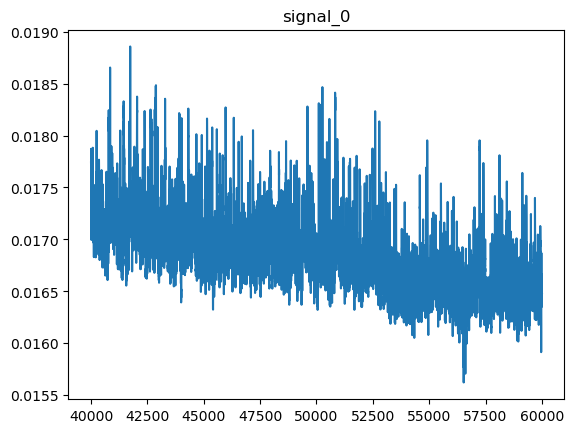

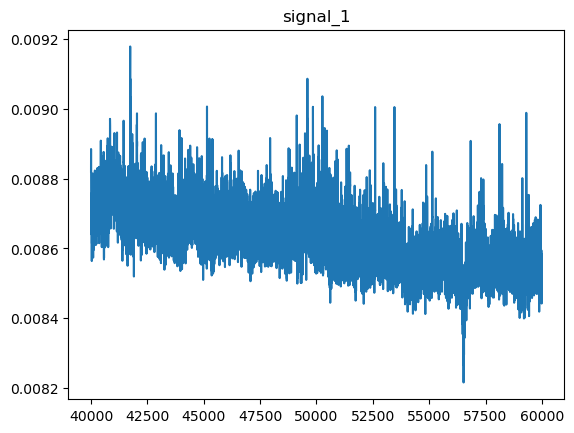

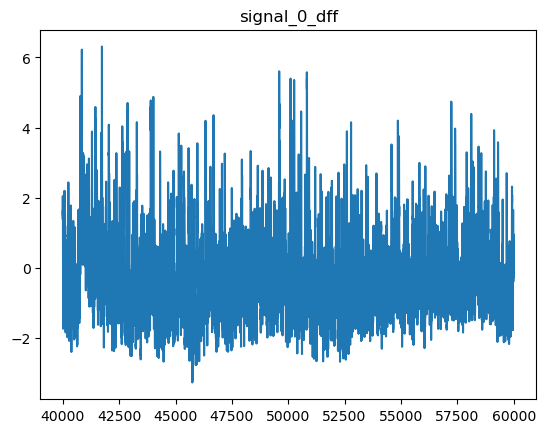

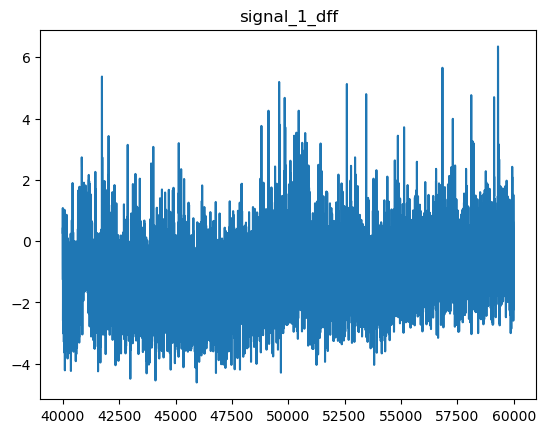

In [11]:
phot_df = session.dfs.data['phot_470']
for col in phot_df.columns:
    if col.startswith('signal'):
        plt.title(col)
        plt.plot(phot_df[col][40000:60000])
        plt.show()

## 6. Assign `signal_info` to Each Session

This step runs through every `(event, ROI)` pair and:
- Snips out a fixed‐length photometry window around each event for that ROI.
- Baseline‐centers each trial’s trace and stacks them into a 2D array.
- Computes summary metrics (e.g., peak amplitude, latency) for each trial.

All of these per‐event, per‐ROI matrices and metrics get saved in `session.signal_info`. That way, you can instantly grab any `(ROI, event)` combination—say, DMS “hit” trials—and plot or analyze their trial‐by‐trial traces without repeating the extraction logic.```

In [12]:

# Assign signal_info for each session, which contains ROI × timepoint matrices
assign_sessions_signal_info(sessions)

# Take the first session for our examples
s0 = sessions[0]

# Print available brain regions and the shape of their signal matrices
for k, v in s0.signal_info.items():
    print(k, v['signal_matrix'].shape)

('DLS', 'G', 'iti_touch') (41, 400)
('DLS', 'G', 'dispimg') (345, 400)
('DLS', 'G', 'hit') (18, 400)
('DLS', 'G', 'mistake') (14, 400)
('DLS', 'G', 'miss') (92, 400)
('DLS', 'G', 'cor_reject') (220, 400)
('DLS', 'G', 'reward_collect') (18, 400)
('DLS', 'G', 'before_dispimg_miss') (92, 400)
('DLS', 'G', 'before_dispimg_cor_reject') (220, 400)
('DLS', 'G', 'before_dispimg_hit') (18, 400)
('DLS', 'G', 'before_dispimg_mistake') (14, 400)
('DLS', 'G', 'after_dispimg_miss') (92, 400)
('DLS', 'G', 'after_dispimg_cor_reject') (220, 400)
('DLS', 'G', 'after_dispimg_hit') (18, 400)
('DLS', 'G', 'after_dispimg_mistake') (14, 400)
('DMS', 'G', 'iti_touch') (41, 400)
('DMS', 'G', 'dispimg') (345, 400)
('DMS', 'G', 'hit') (18, 400)
('DMS', 'G', 'mistake') (14, 400)
('DMS', 'G', 'miss') (92, 400)
('DMS', 'G', 'cor_reject') (220, 400)
('DMS', 'G', 'reward_collect') (18, 400)
('DMS', 'G', 'before_dispimg_miss') (92, 400)
('DMS', 'G', 'before_dispimg_cor_reject') (220, 400)
('DMS', 'G', 'before_dispimg_

Above you can see all of the keys and their corresponding signal matrix, that you can use for easy plotting

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import fiberphotometry.config as config

brain_reg_to_color = {'VS': 'purple',
                      'DMS': 'forestgreen',
                      'DLS': 'C0'}

def preprocess_and_plot_signals(signals, event_type, brain_region, mouse_id, smoothing_len=10):
    """
    Plot mean ± 95% CI of event-aligned signals.
    signals: 2D array (n_trials, n_timepoints), assumed NaN-free or NaN-handled.
    """
    # 1) Bail if no trials left
    if signals.size == 0 or signals.shape[0] == 0:
        print(f"No trials for {event_type}, {brain_region} – skipping plot.")
        return

    interval_start = config.peak_interval_config["interval_start"]
    interval_end   = config.peak_interval_config["interval_end"]
    fps            = config.PLOTTING_CONFIG['cpt']['fps']

    xs = np.arange(-interval_start, interval_end) / fps

    # 2) Use nanmean/nanstd so any stray NaN in 'signals' is ignored
    ys         = np.nanmean(signals, axis=0)
    counts     = np.sum(~np.isnan(signals), axis=0)
    std_signal = np.nanstd(signals, axis=0) / np.sqrt(np.maximum(counts, 1))

    # 3) Smooth, but if ys contains NaN, fill them before smoothing
    ys = np.nan_to_num(ys)
    kernel    = np.ones(smoothing_len)
    numerator = np.convolve(ys,       kernel, mode='same')
    denom     = np.convolve(np.ones_like(ys), kernel, mode='same')
    ys        = numerator / denom

    # 4) 95% CI: guard against zero‐width or NaN std
    alpha    = 0.95
    safe_std = np.where((std_signal>0) & np.isfinite(std_signal), std_signal, 1e-8)
    ci_lower, ci_upper = stats.norm.interval(alpha, loc=ys, scale=safe_std)

    # 5) Determine y‐limits with nan-safe min/max
    lb = np.nanmin(ci_lower)
    ub = np.nanmax(ci_upper)
    if not (np.isfinite(lb) and np.isfinite(ub)):
        ylim = (-1, 1)
    else:
        ylim = (lb, ub)

    color = brain_reg_to_color.get(brain_region, 'black')

    # 6) Plot
    plt.figure(dpi=300)
    plt.plot(xs, ys, color=color, label='Mean Signal')
    plt.fill_between(xs, ci_lower, ci_upper, color=color, alpha=0.2, label='95% CI')
    plt.ylim(ylim)
    plt.title(f'{event_type}, {brain_region}, mouse: {mouse_id}, (n = {signals.shape[0]})')
    plt.xlabel('Time (s)')
    plt.ylabel('z-score')
    plt.legend()
    plt.grid(True)
    plt.show()

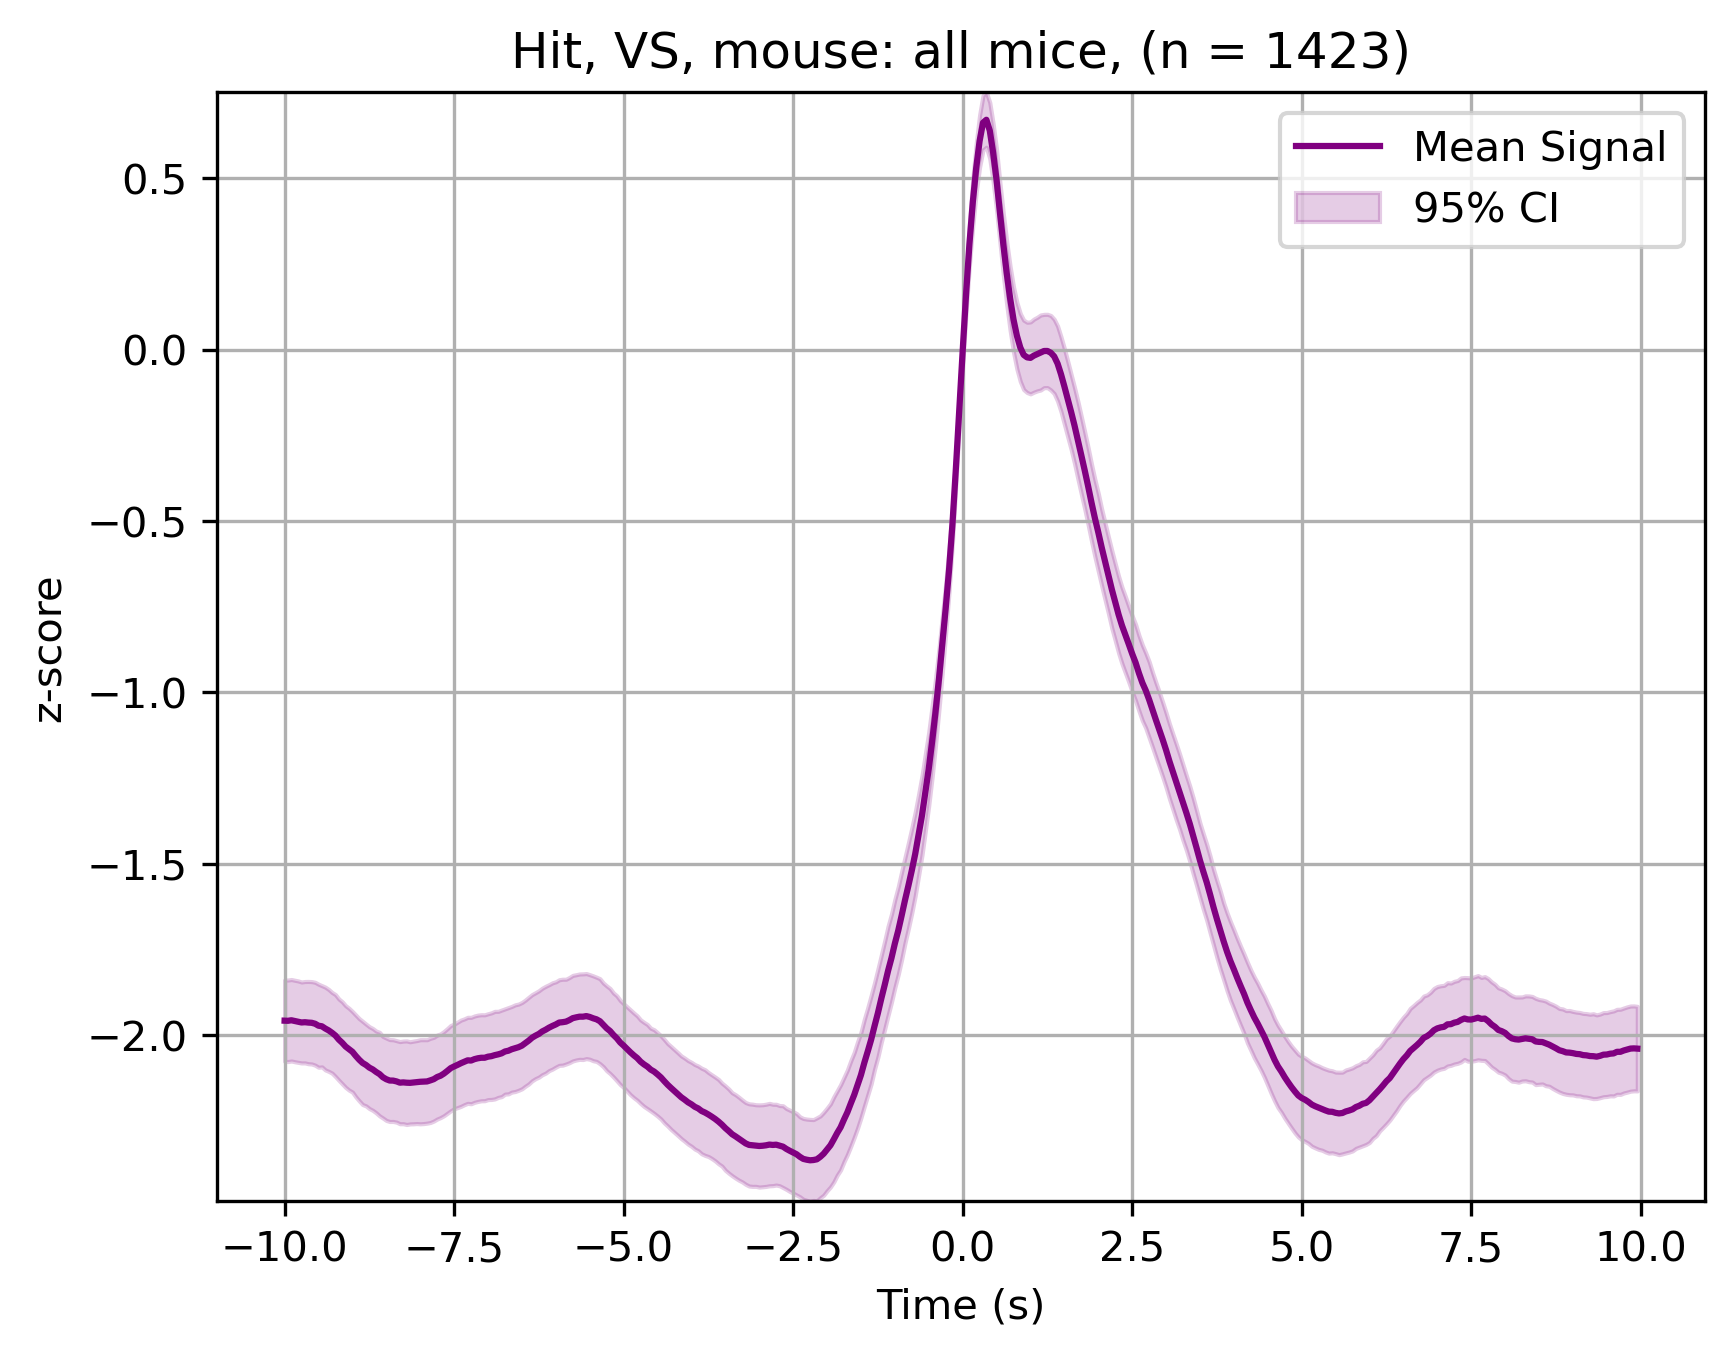

In [19]:
all_signals = []

for session in sessions:
    curr_signal_info = session.signal_info.get(('VS', 'G', 'hit'))
    if curr_signal_info and len(curr_signal_info) >= 3:
        all_signals.append(curr_signal_info['signal_matrix'])

preprocess_and_plot_signals(np.vstack(all_signals), 'Hit', 'VS', 'all mice')

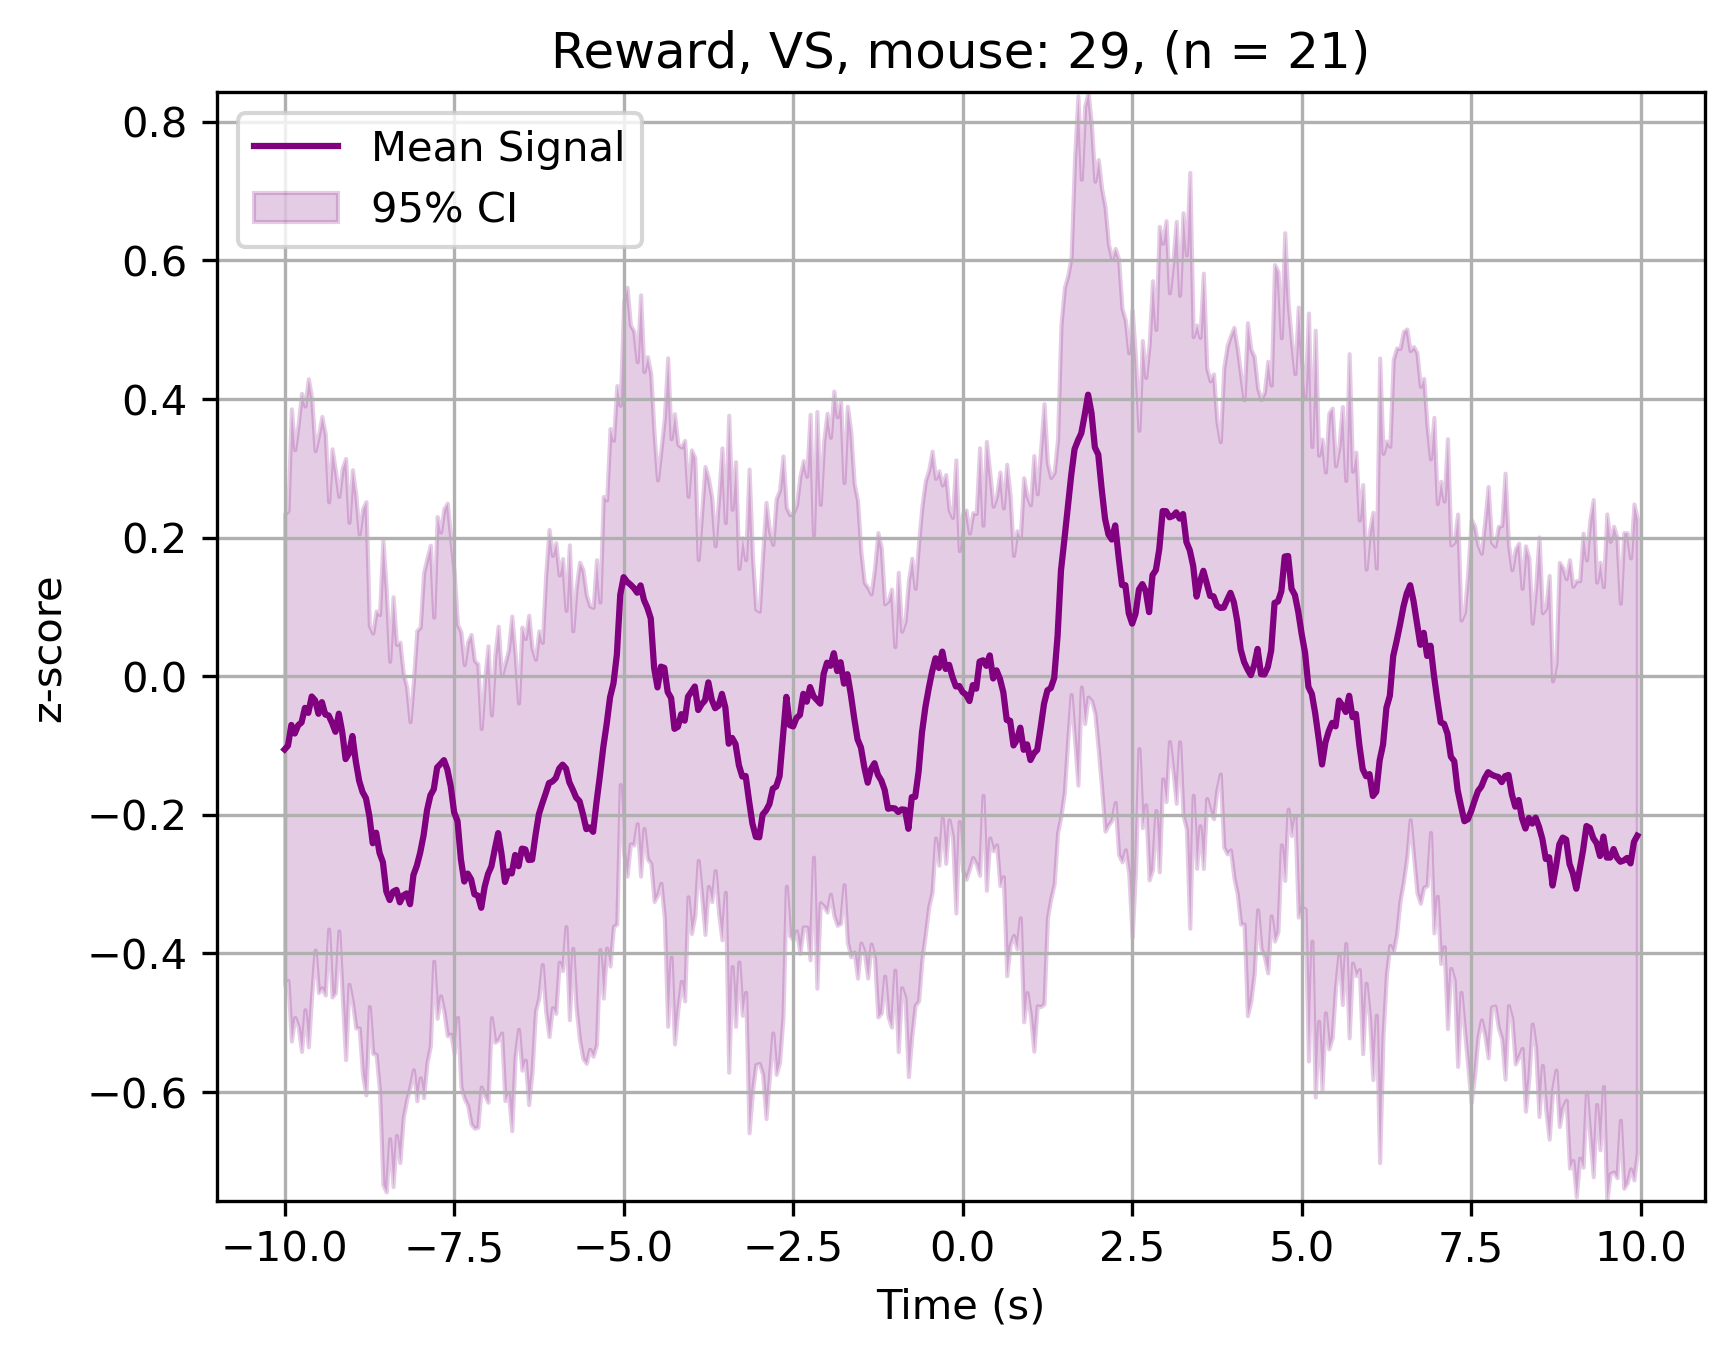

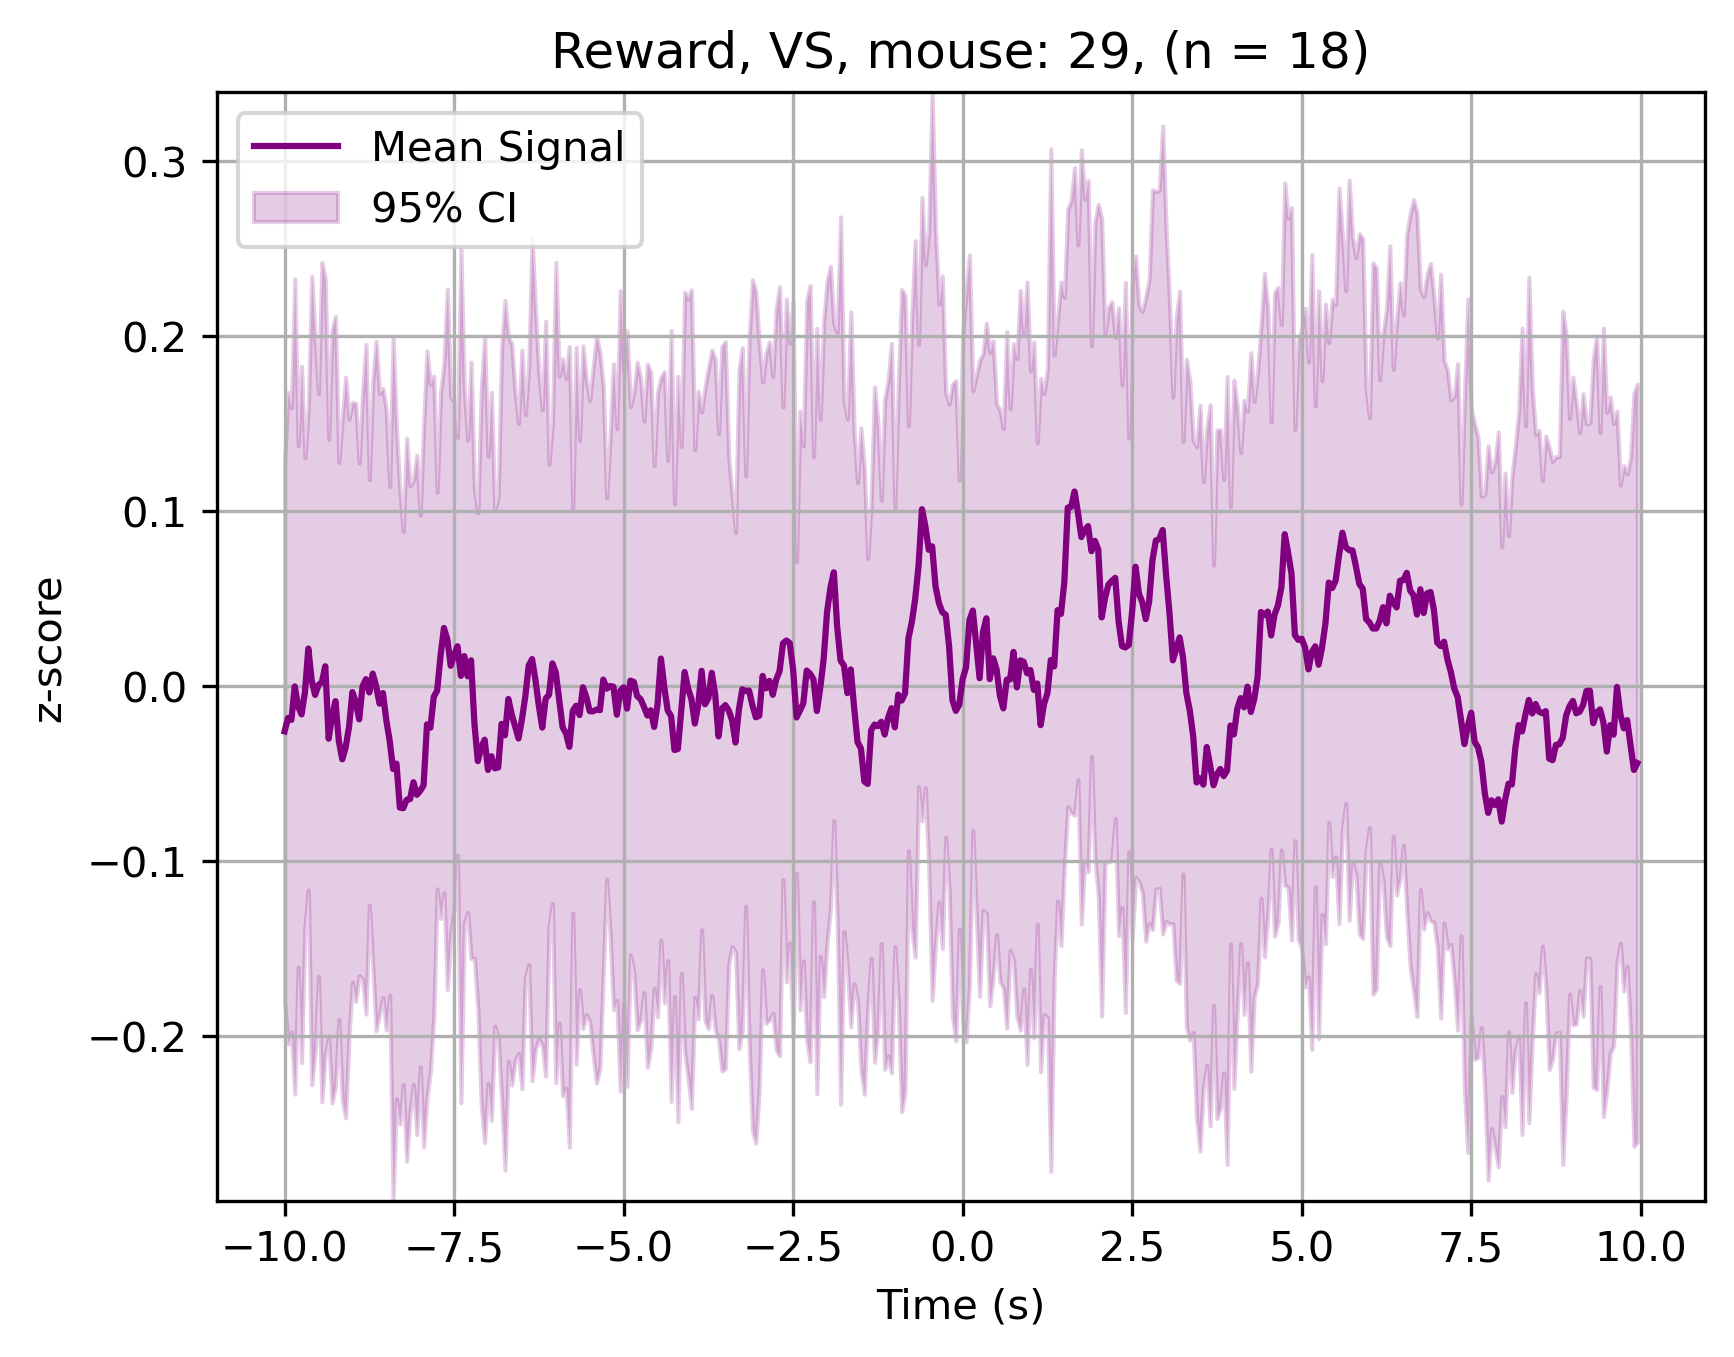

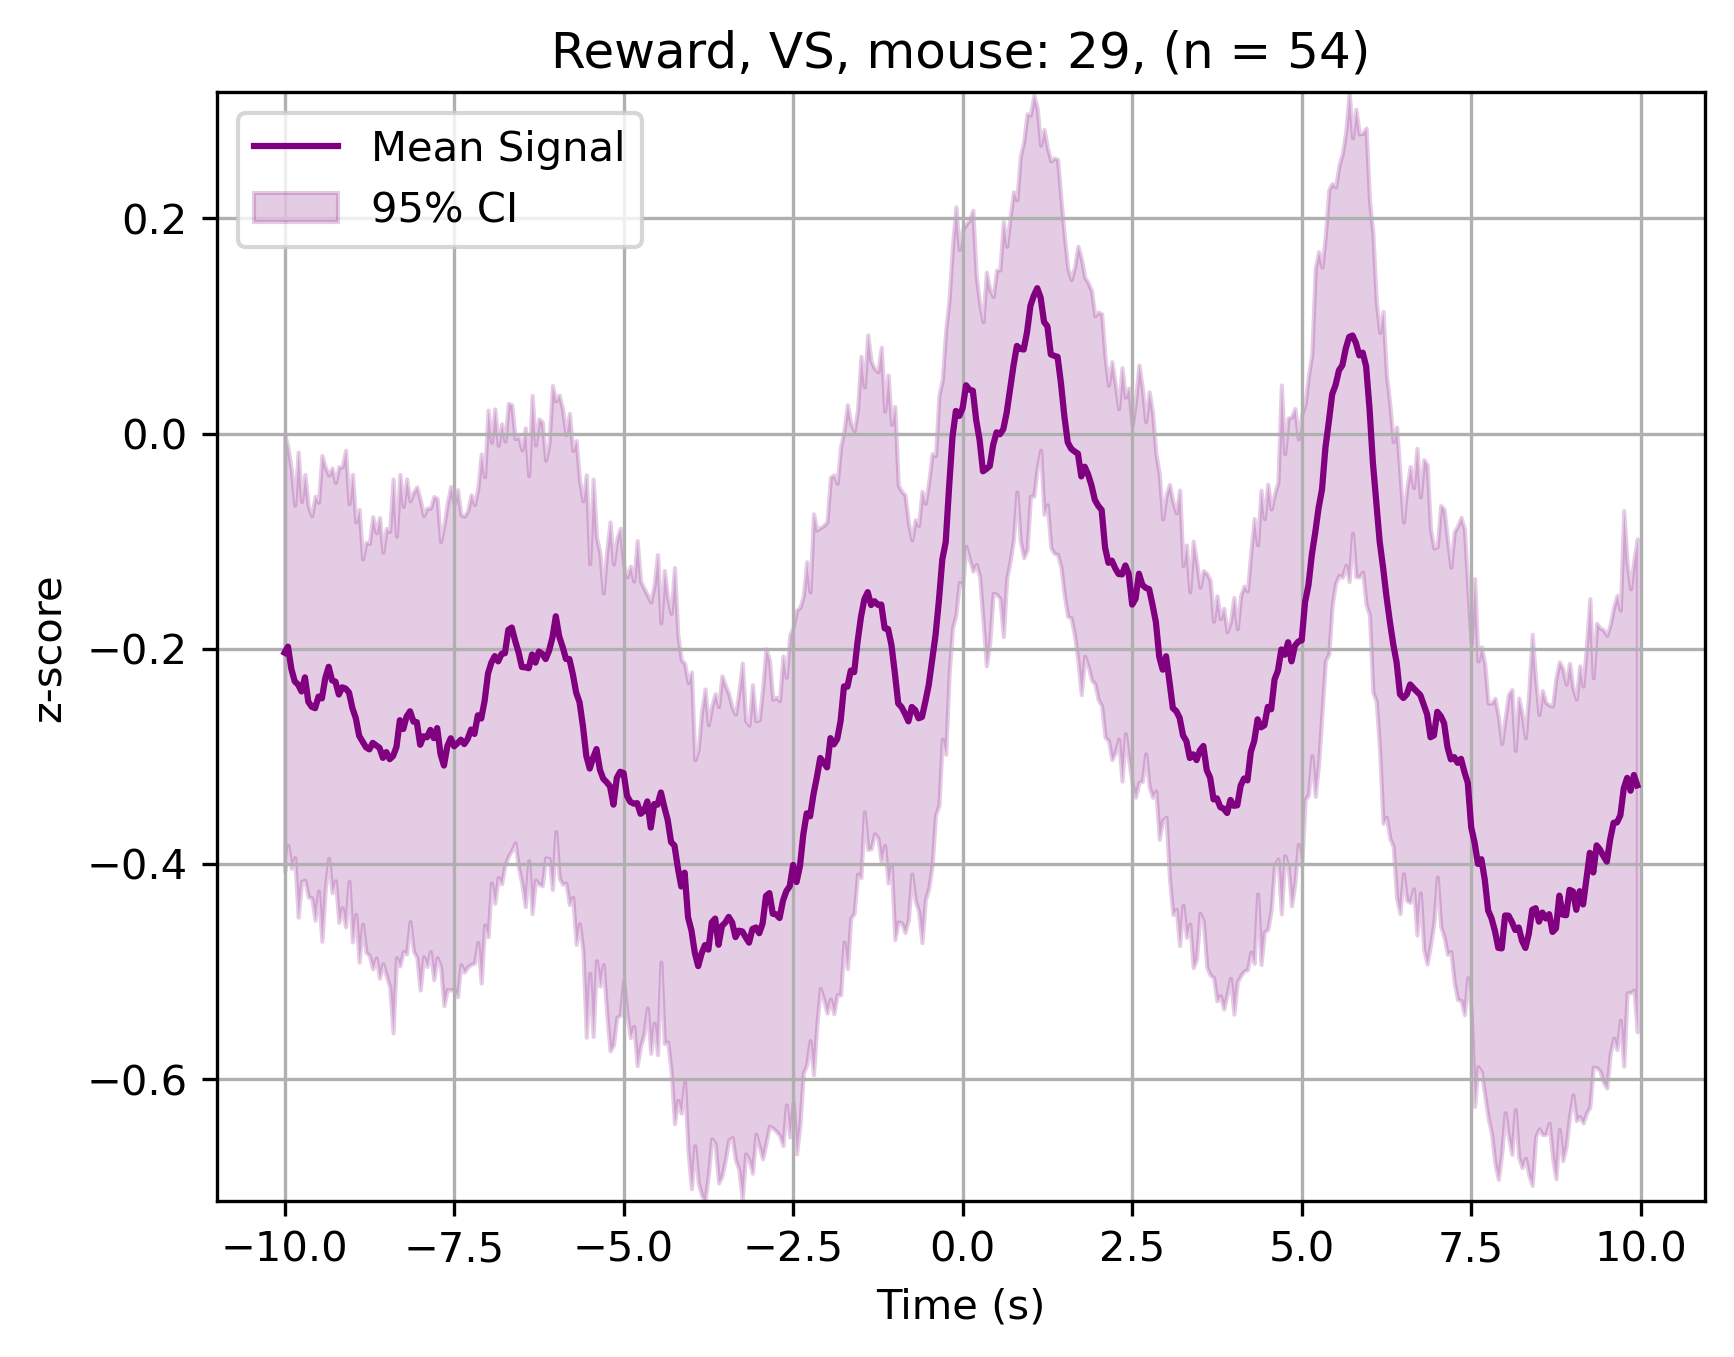

In [ ]:
for session in sessions:
    curr_signal_info = session.signal_info.get(('VS', 'G', 'reward_collect'))
    if curr_signal_info and len(curr_signal_info) >= 3:
        preprocess_and_plot_signals(curr_signal_info['signal_matrix'], 'Reward', 'VS', session.mouse_id)